In [1]:
!pip install pystan>=3.0 arviz

In [2]:
# Import libraries
import stan
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Preare stan data

Version 1

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('merged_ANH_stan.csv')

# Choose the number of subjects to sample
num_subjects_to_sample = 5  # Change this to include a different number of subjects

# Get unique subject IDs and sort them
subj_map = {subj: idx + 1 for idx, subj in enumerate(df['subjid'].unique())}
df['subjid_num'] = df['subjid'].map(subj_map)  # Replace subjid with numerical index

# Select only the first `num_subjects_to_sample` subjects
selected_subjects = list(subj_map.values())[:num_subjects_to_sample]
df_selected = df[df['subjid_num'].isin(selected_subjects)]

# Get unique numerical subjects in selected dataset
unique_subjects = np.array(sorted(df_selected['subjid_num'].unique()))
N = len(unique_subjects)
max_trials = df_selected.groupby('subjid_num').size().max()

# Initialize data arrays
Tsubj = np.zeros(N, dtype=int)
rew_matrix = np.zeros((N, max_trials), dtype=np.float32)
los_matrix = np.zeros((N, max_trials), dtype=np.float32)
choice_matrix = np.full((N, max_trials), -1, dtype=int)  # Initialize with -1 instead of 0

# Fill matrices using numerical subject IDs
for idx, subj in enumerate(unique_subjects):
    subj_data = df_selected[df_selected['subjid_num'] == subj]
    num_trials = len(subj_data)

    Tsubj[idx] = num_trials
    rew_matrix[idx, :num_trials] = subj_data['gain'].to_numpy()
    los_matrix[idx, :num_trials] = subj_data['loss'].to_numpy()

    # Only populate valid trials in choice_matrix
    choice_vals = subj_data['choice'].to_numpy().astype(int)
    choice_matrix[idx, :num_trials] = choice_vals

# **Fix: Replace -1 with 1 before passing to Stan**
choice_matrix_fixed = np.where(choice_matrix == -1, 1, choice_matrix)  # Replace -1 with 1

# Number of unique choices
Narm = df_selected['choice'].nunique()

# Prepare data for Stan
stan_data = {
    'N': N,
    'T': max_trials,
    'Tsubj': Tsubj,
    'rew': rew_matrix,
    'los': los_matrix,
    'choice': choice_matrix_fixed,  # Use the fixed version
    'Narm': Narm
}

# Store mapping in case it's needed later
subj_map_df = pd.DataFrame(list(subj_map.items()), columns=['Original_Subjid', 'Numeric_Index'])
subj_map_df.to_csv('subjid_mapping.csv', index=False)

# Assertions to verify correctness
assert rew_matrix.shape == (N, max_trials), "Incorrect shape for rew_matrix"
assert los_matrix.shape == (N, max_trials), "Incorrect shape for los_matrix"
assert choice_matrix_fixed.shape == (N, max_trials), "Incorrect shape for choice_matrix"
assert len(Tsubj) == N, "Incorrect length for Tsubj array"

# Print Samples for Validation
print(f"Sampling {num_subjects_to_sample} subjects...")
print("Rew Matrix Sample:\n", rew_matrix[:5])
print("Los Matrix Sample:\n", los_matrix[:5])
print("Choice Matrix Sample (Check -1 for padding before fix):\n", choice_matrix[:5])
print("Choice Matrix Sample (After Fix, No -1s):\n", choice_matrix_fixed[:5])
print("Tsubj Sample (Trial Counts Per Subject):\n", Tsubj[:5])
print("Subject Mapping Sample:\n", subj_map_df.head())

# Ensure no unexpected 0s or -1s in choice_matrix_fixed
print("Unique values in choice_matrix_fixed:", np.unique(choice_matrix_fixed))


Version 2

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
file_path = "merged_ANH_stan.csv"  # Adjust if needed
df = pd.read_csv(file_path)

# **1️⃣ Ensure subjid mapping is sorted**
sorted_subjects = sorted(df['subjid'].unique())  # Ensure consistent subject order
subj_map = {subj: idx + 1 for idx, subj in enumerate(sorted_subjects)}
df['subjid_num'] = df['subjid'].map(subj_map)  # Replace subjid with numerical index

# Choose number of subjects to sample
num_subjects_to_sample = 5  # Change to adjust the number of subjects

# **2️⃣ Select only the first `num_subjects_to_sample` subjects**
selected_subjects = list(subj_map.values())[:num_subjects_to_sample]
df_selected = df[df['subjid_num'].isin(selected_subjects)]

# **3️⃣ Ensure trial counts are correct**
trial_counts = df_selected.groupby('subjid_num').size()
print("Trial counts per subject:\n", trial_counts)

# Get unique numerical subjects in selected dataset
unique_subjects = np.array(sorted(df_selected['subjid_num'].unique()))
N = len(unique_subjects)
max_trials = trial_counts.max()  # Get the correct max_trials

# **4️⃣ Initialize data arrays**
Tsubj = np.zeros(N, dtype=int)
rew_matrix = np.full((N, max_trials), np.nan, dtype=np.float32)  # Fill with NaN initially
los_matrix = np.full((N, max_trials), np.nan, dtype=np.float32)
choice_matrix = np.full((N, max_trials), -1, dtype=int)  # Fill with -1 initially

# **5️⃣ Fill matrices using numerical subject IDs**
for idx, subj in enumerate(unique_subjects):
    subj_data = df_selected[df_selected['subjid_num'] == subj]
    num_trials = len(subj_data)

    Tsubj[idx] = num_trials  # Store actual trial count
    rew_matrix[idx, :num_trials] = subj_data['gain'].to_numpy()
    los_matrix[idx, :num_trials] = subj_data['loss'].to_numpy()

    # Only populate valid trials in choice_matrix
    choice_vals = subj_data['choice'].to_numpy().astype(int)
    choice_matrix[idx, :num_trials] = choice_vals

# **6️⃣ Validate Last Subject Data Integrity**
print(f"Last subject ({unique_subjects[-1]}) trials:", Tsubj[-1])
print("Choice matrix sample for last subject:\n", choice_matrix[-1, :10])

# **7️⃣ Fix: Replace only valid trials in choice_matrix_fixed**
choice_matrix_fixed = np.full((N, max_trials), -1, dtype=int)  # Reinitialize
for idx in range(N):
    choice_matrix_fixed[idx, :Tsubj[idx]] = choice_matrix[idx, :Tsubj[idx]]  # Ensure only real trials are filled

# **8️⃣ Ensure no unexpected 0s or -1s in choice_matrix_fixed**
print("Unique values in choice_matrix_fixed:", np.unique(choice_matrix_fixed))

# **9️⃣ Number of unique choices**
Narm = df_selected['choice'].nunique()

# **10️⃣ Prepare data for Stan**
stan_data = {
    'N': N,
    'T': max_trials,
    'Tsubj': Tsubj,
    'rew': rew_matrix,
    'los': los_matrix,
    'choice': choice_matrix_fixed,  # Use the fixed version
    'Narm': Narm
}

# **11️⃣ Assertions to verify correctness**
assert rew_matrix.shape == (N, max_trials), "Incorrect shape for rew_matrix"
assert los_matrix.shape == (N, max_trials), "Incorrect shape for los_matrix"
assert choice_matrix_fixed.shape == (N, max_trials), "Incorrect shape for choice_matrix"
assert len(Tsubj) == N, "Incorrect length for Tsubj array"

# **12️⃣ Print Samples for Validation**
print(f"✅ Successfully sampled {num_subjects_to_sample} subjects")
print("Rew Matrix Sample:\n", rew_matrix[:5])
print("Los Matrix Sample:\n", los_matrix[:5])
print("Choice Matrix Sample (Check -1 for padding before fix):\n", choice_matrix[:5])
print("Choice Matrix Sample (After Fix, No -1s):\n", choice_matrix_fixed[:5])
print("Tsubj Sample (Trial Counts Per Subject):\n", Tsubj[:5])

# **13️⃣ Display subject mappings**
print("Subject Mapping:\n", subj_map)


Version 3 including online "anhedonic" subjects as well

In [3]:
import pandas as pd
import numpy as np

# **1️⃣ Load dataset**
file_path = "merged_ANH_stan.csv"
df = pd.read_csv(file_path)
print(f"✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# **2️⃣ Ensure subjid mapping is sorted**
df['subjid'] = df['subjid'].astype(str)  # Ensure subjid is treated as a string
sorted_subjects = sorted(df['subjid'].unique())  # Ensure consistent subject order
subj_map = {subj: idx + 1 for idx, subj in enumerate(sorted_subjects)}
df['subjid_num'] = df['subjid'].map(subj_map)  # Replace subjid with numerical index
print(f"✅ Unique subjects mapped: {len(subj_map)} subjects")

# **3️⃣ Include all 134 subjects**
num_subjects_to_sample = 134  # Use all subjects
selected_subjects = list(subj_map.values())[:num_subjects_to_sample]
df_selected = df[df['subjid_num'].isin(selected_subjects)]
print(f"✅ Selected {df_selected['subjid_num'].nunique()} subjects for analysis")

# **4️⃣ Normalize trial numbers per subject** (Ensure trial 1 starts at the first recorded trial)
df_selected['trial'] = df_selected.groupby('subjid_num')['trial'].transform(lambda x: x - x.min() + 1)
print("✅ Trial numbers renormalized per subject")

# **5️⃣ Ensure trial counts are correct**
trial_counts = df_selected.groupby('subjid_num')['trial'].count()
print(f"✅ Trial counts per subject (sample): {trial_counts.head()}")

# **6️⃣ Define key parameters**
unique_subjects = np.array(sorted(df_selected['subjid_num'].unique()))
N = len(unique_subjects)  # Number of subjects
max_trials = trial_counts.max()  # Get the max trial count across subjects
print(f"✅ Number of subjects: {N}, Maximum trials across subjects: {max_trials}")

# **7️⃣ Initialize matrices for Stan**
Tsubj = np.zeros(N, dtype=int)
rew_matrix = np.full((N, max_trials), np.nan, dtype=np.float32)
los_matrix = np.full((N, max_trials), np.nan, dtype=np.float32)
choice_matrix = np.full((N, max_trials), -1, dtype=int)  # Initialize with -1 for missing trials

# **8️⃣ Fill matrices with trial data**
for idx, subj in enumerate(unique_subjects):
    subj_data = df_selected[df_selected['subjid_num'] == subj].sort_values('trial')
    num_trials = len(subj_data)

    Tsubj[idx] = num_trials  # Store actual trial count
    rew_matrix[idx, :num_trials] = subj_data['gain'].to_numpy()
    los_matrix[idx, :num_trials] = subj_data['loss'].to_numpy()

    # Populate only valid trials in choice_matrix
    choice_vals = subj_data['choice'].to_numpy().astype(int)
    choice_matrix[idx, :num_trials] = choice_vals

print(f"✅ Data matrices initialized and filled")

# **9️⃣ Ensure choice matrix only contains real trials**
choice_matrix_fixed = np.full((N, max_trials), -1, dtype=int)  # Reinitialize
for idx in range(N):
    choice_matrix_fixed[idx, :Tsubj[idx]] = choice_matrix[idx, :Tsubj[idx]]  # Ensure only real trials are filled

# **🔍 10️⃣ Data validation checks**
unique_choice_values = np.unique(choice_matrix_fixed)  # Ensure only valid values
unique_loss_values = np.unique(los_matrix)  # Ensure loss values are correctly recoded

print(f"✅ Unique values in choice_matrix_fixed: {unique_choice_values}")
print(f"✅ Unique values in loss matrix (should be 0, -1): {unique_loss_values}")

# **11️⃣ Get number of unique choices**
Narm = df_selected['choice'].nunique()
print(f"✅ Number of unique choices: {Narm}")

# **12️⃣ Prepare data for Stan**
stan_data = {
    'N': N,  # Number of subjects
    'T': max_trials,  # Maximum trials across subjects
    'Tsubj': Tsubj,  # Number of trials per subject
    'rew': rew_matrix,  # Reward outcomes
    'los': los_matrix,  # Loss outcomes
    'choice': choice_matrix_fixed,  # Choices made
    'Narm': Narm  # Number of choice options
}

# **13️⃣ Final assertions to ensure correctness**
assert rew_matrix.shape == (N, max_trials), "Error: rew_matrix shape incorrect"
assert los_matrix.shape == (N, max_trials), "Error: los_matrix shape incorrect"
assert choice_matrix_fixed.shape == (N, max_trials), "Error: choice_matrix shape incorrect"
assert len(Tsubj) == N, "Error: Tsubj length incorrect"

print(f"✅ Successfully processed {N} subjects for Stan modeling.")


✅ Dataset loaded: 26117 rows, 8 columns
✅ Unique subjects mapped: 134 subjects
✅ Selected 134 subjects for analysis
✅ Trial numbers renormalized per subject
✅ Trial counts per subject (sample): subjid_num
1    197
2    200
3    199
4    198
5    199
Name: trial, dtype: int64
✅ Number of subjects: 134, Maximum trials across subjects: 300
✅ Data matrices initialized and filled
✅ Unique values in choice_matrix_fixed: [-1  1  2  3]
✅ Unique values in loss matrix (should be 0, -1): [-1.  0. nan]
✅ Number of unique choices: 3
✅ Successfully processed 134 subjects for Stan modeling.


In [4]:
subj_map

{'55d0e4d334e9060005e574c7': 1,
 '55d621bbdb6a810013fa0ea0': 2,
 '56296779c8ffc200055134c9': 3,
 '57067bd53409da000f19a0ba': 4,
 '5781511fad1a6c00014658b7': 5,
 '57a6891d8eccbc0001f39f89': 6,
 '57fde8979c39b3000179e347': 7,
 '5873b2d22bd3c90001859b76': 8,
 '58c57ce2a47dbb000171c9ca': 9,
 '58cc4c53efb64f0001359761': 10,
 '596e5141fe061d00011e3984': 11,
 '598caf6833481c000164d13d': 12,
 '59b6d5df6039190001eaa9ce': 13,
 '59f7c290f4217300016cc2fb': 14,
 '5a051341ff266c0001d1f915': 15,
 '5a9bf9bd89de8200013f0f28': 16,
 '5aa087cd6475f90001a02c9c': 17,
 '5aafd9eff69e940001d88bf4': 18,
 '5ac76c50e734400001da4db3': 19,
 '5ad8affa4efee10001f537fd': 20,
 '5b033abaa496b300013d78ce': 21,
 '5b3a76c6c49ecb00010a8336': 22,
 '5b6b2c3156558d0001678ffc': 23,
 '5be9c2e7baa65d000184d1b6': 24,
 '5c4782d9cae0ab000188d2b4': 25,
 '5c51d18698b0ff000110da96': 26,
 '5c715fc303f85b0001af916a': 27,
 '5c7e33aa19b8d40017e6dd80': 28,
 '5c84d2370d4ac0001196cde4': 29,
 '5ca216d52a83ec00175c4eaf': 30,
 '5d1a05e0628de0001

In [5]:
stan_model_code = """
// Seymour et al 2012 J Neuro model, w/o C (choice perseveration)
data {
  int<lower=1> N;
  int<lower=1> T;
  array[N] int<lower=1, upper=T> Tsubj;
  array[N, T] real rew;
  array[N, T] real los;
  array[N, T] int choice;
  int Narm;
}

transformed data {
  vector[Narm] initV;
  initV = rep_vector(0.0, Narm);
}

parameters {
  // Declare all parameters as vectors for vectorizing
  // Hyper(group)-parameters
  vector[4] mu_pr;
  vector<lower=0>[4] sigma;

  // Subject-level raw parameters (for Matt trick)
  vector[N] Arew_pr;
  vector[N] Apun_pr;
  vector[N] R_pr;
  vector[N] P_pr;
}

transformed parameters {
  // Transform subject-level raw parameters
  vector<lower=0, upper=1>[N] Arew;
  vector<lower=0, upper=1>[N] Apun;
  vector<lower=0, upper=30>[N] R;
  vector<lower=0, upper=30>[N] P;

  for (i in 1:N) {
    Arew[i] = Phi_approx(mu_pr[1] + sigma[1] * Arew_pr[i]);
    Apun[i] = Phi_approx(mu_pr[2] + sigma[2] * Apun_pr[i]);
    R[i]    = Phi_approx(mu_pr[3] + sigma[3] * R_pr[i]) * 30;
    P[i]    = Phi_approx(mu_pr[4] + sigma[4] * P_pr[i]) * 30;
  }
}

model {
  // Hyperparameters
  mu_pr  ~ normal(0, 1);
  sigma ~ normal(0, 0.2);

  // Individual parameters
  Arew_pr  ~ normal(0, 1.0);
  Apun_pr  ~ normal(0, 1.0);
  R_pr     ~ normal(0, 1.0);
  P_pr     ~ normal(0, 1.0);

  for (i in 1:N) {
    // Define values
    vector[Narm] Qr;
    vector[Narm] Qp;
    vector[Narm] PEr_fic; // prediction error - for reward fictive updating (for unchosen options)
    vector[Narm] PEp_fic; // prediction error - for punishment fictive updating (for unchosen options)
    vector[Narm] Qsum;    // Qsum = Qrew + Qpun + perseverance

    real Qr_chosen;
    real Qp_chosen;
    real PEr; // prediction error - for reward of the chosen option
    real PEp; // prediction error - for punishment of the chosen option

    // Initialize values
    Qr    = initV;
    Qp    = initV;
    Qsum  = initV;

    for (t in 1:Tsubj[i]) {
      // Softmax choice
      choice[i, t] ~ categorical_logit(Qsum);

      // Prediction error signals
      PEr     = R[i] * rew[i, t] - Qr[choice[i, t]];
      PEp     = P[i] * los[i, t] - Qp[choice[i, t]];
      PEr_fic = -Qr;
      PEp_fic = -Qp;

      // Store chosen deck Q values (rew and pun)
      Qr_chosen = Qr[choice[i, t]];
      Qp_chosen = Qp[choice[i, t]];

      // First, update Qr & Qp for all decks w/ fictive updating
      Qr += Arew[i] * PEr_fic;
      Qp += Apun[i] * PEp_fic;
      // Replace Q values of chosen deck with correct values using stored values
      Qr[choice[i, t]] = Qr_chosen + Arew[i] * PEr;
      Qp[choice[i, t]] = Qp_chosen + Apun[i] * PEp;

      // Q(sum)
      Qsum = Qr + Qp;
    }
  }
}

generated quantities {
  // For group level parameters
  real<lower=0, upper=1> mu_Arew;
  real<lower=0, upper=1> mu_Apun;
  real<lower=0, upper=30> mu_R;
  real<lower=0, upper=30> mu_P;

  // For log likelihood calculation
  array[N] real log_lik;

  // For posterior predictive check
  array[N, T] real y_pred;

  // Matrix to store rew prediction errors
  array[N, T] real rew_pred_error;

  // Matrix to store pun prediction errors
  array[N, T] real pun_pred_error;

  // Set all posterior predictions to -1 (avoids NULL values)
  for (i in 1:N) {
    for (t in 1:T) {
      y_pred[i, t] = -1;
    }
  }

  mu_Arew = Phi_approx(mu_pr[1]);
  mu_Apun = Phi_approx(mu_pr[2]);
  mu_R    = Phi_approx(mu_pr[3]) * 30;
  mu_P    = Phi_approx(mu_pr[4]) * 30;

  { // Local section, this saves time and space
    for (i in 1:N) {
      // Define values
      vector[Narm] Qr;
      vector[Narm] Qp;
      vector[Narm] PEr_fic; // prediction error - for reward fictive updating (for unchosen options)
      vector[Narm] PEp_fic; // prediction error - for punishment fictive updating (for unchosen options)
      vector[Narm] Qsum;    // Qsum = Qrew + Qpun + perseverance

      real Qr_chosen;
      real Qp_chosen;
      real PEr; // prediction error - for reward of the chosen option
      real PEp; // prediction error - for punishment of the chosen option

      // Initialize values
      Qr   = initV;
      Qp   = initV;
      Qsum = initV;
      log_lik[i] = 0.0;

      for (t in 1:Tsubj[i]) {
        // Compute log likelihood of current trial
        log_lik[i] += categorical_logit_lpmf(choice[i, t] | Qsum);

        // Generate posterior prediction for current trial
        y_pred[i, t] = categorical_rng(softmax(Qsum));

        // Prediction error signals
        PEr     = R[i] * rew[i, t] - Qr[choice[i, t]];
        PEp     = P[i] * los[i, t] - Qp[choice[i, t]];
        rew_pred_error[i, t] = PEr; // Store prediction error for reward
        pun_pred_error[i, t] = PEp; // Store prediction error for punishment
        PEr_fic = -Qr;
        PEp_fic = -Qp;

        // Store chosen deck Q values (rew and pun)
        Qr_chosen = Qr[choice[i, t]];
        Qp_chosen = Qp[choice[i, t]];

        // First, update Qr & Qp for all decks w/ fictive updating
        Qr += Arew[i] * PEr_fic;
        Qp += Apun[i] * PEp_fic;
        // Replace Q values of chosen deck with correct values using stored values
        Qr[choice[i, t]] = Qr_chosen + Arew[i] * PEr;
        Qp[choice[i, t]] = Qp_chosen + Apun[i] * PEp;

        // Q(sum)
        Qsum = Qr + Qp;
      }
    }
  }
}

"""


In [6]:
!pip install nest_asyncio

In [7]:
import nest_asyncio
nest_asyncio.apply()

In [8]:
posterior = stan.build(stan_model_code, data=stan_data, random_seed=123)


Building...



Building: 41.4s, done.

In [ ]:
 # Sample from the posterior
fit = posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)

Saving the sampled fit

In [ ]:
import pickle

# Save the sampled fit object
with open("fit_results.pkl", "wb") as f:
    pickle.dump(fit, f)

print("Saved sampled results to 'fit_results.pkl'")


In [ ]:
import pickle

# Load the saved fit object
with open("fit_results.pkl", "rb") as f:
    fit = pickle.load(f)

print("Loaded sampled results from 'fit_results.pkl'")


In [ ]:
parameter_samples = fit.to_frame()

In [ ]:
import pandas as pd
from IPython.display import display

# Extract all parameter samples into a DataFrame
parameter_samples = fit.to_frame()

# Compute summary statistics for all parameters
parameter_summary = parameter_samples.describe().T  # Transpose to match format of `print(fit)`
parameter_summary.reset_index(inplace=True)
parameter_summary.rename(columns={'index': 'Parameter'}, inplace=True)

# Display all rows and columns in the summary
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the full summary in the notebook
print(parameter_summary)

# Alternatively, display as an HTML table (more readable in Colab)
display(parameter_summary)

# Save the summary to a CSV file for offline inspection
#parameter_summary.to_csv('parameter_summary.csv', index=False)

# Provide a download link to retrieve the file
#from google.colab import files
#files.download('parameter_summary.csv')


                parameters   count          mean           std           min  \
0                     lp__  8000.0 -1.011696e+03  4.020141e+00 -1.030798e+03   
1            accept_stat__  8000.0  9.466702e-01  7.583952e-02  2.075540e-01   
2               stepsize__  8000.0  5.822619e-02  5.412275e-03  5.172685e-02   
3              treedepth__  8000.0  6.023875e+00  2.780551e-01  4.000000e+00   
4             n_leapfrog__  8000.0  7.510400e+01  2.836607e+01  3.100000e+01   
5              divergent__  8000.0  0.000000e+00  0.000000e+00  0.000000e+00   
6                 energy__  8000.0  1.025657e+03  5.429105e+00  1.009920e+03   
7                  mu_pr.1  8000.0  3.596752e-02  4.162050e-01 -2.795093e+00   
8                  mu_pr.2  8000.0 -2.051087e-01  3.922044e-01 -2.006389e+00   
9                  mu_pr.3  8000.0 -1.695359e+00  3.285010e-01 -3.488293e+00   
10                 mu_pr.4  8000.0 -1.577653e+00  2.385873e-01 -2.575108e+00   
11                 sigma.1  8000.0  3.21

parameters   count          mean           std           min  \
0                     lp__  8000.0 -1.011696e+03  4.020141e+00 -1.030798e+03   
1            accept_stat__  8000.0  9.466702e-01  7.583952e-02  2.075540e-01   
2               stepsize__  8000.0  5.822619e-02  5.412275e-03  5.172685e-02   
3              treedepth__  8000.0  6.023875e+00  2.780551e-01  4.000000e+00   
4             n_leapfrog__  8000.0  7.510400e+01  2.836607e+01  3.100000e+01   
5              divergent__  8000.0  0.000000e+00  0.000000e+00  0.000000e+00   
6                 energy__  8000.0  1.025657e+03  5.429105e+00  1.009920e+03   
7                  mu_pr.1  8000.0  3.596752e-02  4.162050e-01 -2.795093e+00   
8                  mu_pr.2  8000.0 -2.051087e-01  3.922044e-01 -2.006389e+00   
9                  mu_pr.3  8000.0 -1.695359e+00  3.285010e-01 -3.488293e+00   
10                 mu_pr.4  8000.0 -1.577653e+00  2.385873e-01 -2.575108e+00   
11                 sigma.1  8000.0  3.212048e-01  1.571341e-01  6.573736e-04   
12                 sigma.2  8000.0  2.550893e-01  1.633230e-01  2.328978e-04   
13                 sigma.3  8000.0  5.737062e-01  1.307510e-01  5.359426e-03   
14                 sigma.4  8000.0  3.495935e-01  1.087965e-01  1.882659e-03   
15               Arew_pr.1  8000.0  1.223641e+00  8.604636e-01 -3.232357e+00   
16               Arew_pr.2  8000.0 -7.049313e-01  9.623387e-01 -4.280406e+00   
17               Arew_pr.3  8000.0 -2.675459e-01  1.071753e+00 -4.014870e+00   
18               Arew_pr.4  8000.0  3.178639e-02  1.058843e+00 -4.151114e+00   
19               Arew_pr.5  8000.0 -2.809259e-01  1.067227e+00 -4.185360e+00   
20               Apun_pr.1  8000.0  8.348936e-01  1.040391e+00 -3.619434e+00   
21               Apun_pr.2  8000.0 -5.623514e-01  1.046737e+00 -4.614637e+00   
22               Apun_pr.3  8000.0  8.662269e-02  9.053720e-01 -3.595265e+00   
23               Apun_pr.4  8000.0 -4.981890e-01  1.014322e+00 -4.037423e+00   
24               Apun_pr.5  8000.0  8.291905e-02  9.642446e-01 -4.711742e+00   
25                  R_pr.1  8000.0  1.402596e+00  6.193263e-01 -2.145130e+00   
26                  R_pr.2  8000.0  1.636016e+00  5.992205e-01 -2.154008e+00   
27                  R_pr.3  8000.0 -1.731514e+00  7.374814e-01 -4.390610e+00   
28                  R_pr.4  8000.0 -8.843002e-01  6.725736e-01 -3.877677e+00   
29                  R_pr.5  8000.0 -1.348626e+00  7.371870e-01 -4.435394e+00   
30                  P_pr.1  8000.0  1.653495e+00  7.046199e-01 -1.948195e+00   
31                  P_pr.2  8000.0 -4.975039e-01  8.525052e-01 -3.805387e+00   
32                  P_pr.3  8000.0  5.700646e-03  6.647787e-01 -2.997256e+00   
33                  P_pr.4  8000.0 -1.060941e+00  7.524430e-01 -3.813471e+00   
34                  P_pr.5  8000.0 -6.681414e-01  6.924111e-01 -4.359356e+00   
35                  Arew.1  8000.0  6.721118e-01  6.704191e-02  4.299634e-01   
36                  Arew.2  8000.0  4.524688e-01  6.875195e-02  2.415697e-01   
37                  Arew.3  8000.0  4.917740e-01  1.930702e-01  9.519694e-12   
38                  Arew.4  8000.0  5.278413e-01  1.877876e-01  1.616739e-07   
39                  Arew.5  8000.0  4.886965e-01  1.929144e-01  2.891912e-05   
40                  Apun.1  8000.0  5.288805e-01  7.580926e-02  2.635721e-01   
41                  Apun.2  8000.0  3.697163e-01  1.847908e-01  6.318075e-03   
42                  Apun.3  8000.0  4.397485e-01  1.485587e-01  9.231459e-03   
43                  Apun.4  8000.0  3.771095e-01  1.817809e-01  1.275051e-03   
44                  Apun.5  8000.0  4.392984e-01  1.616617e-01  1.841442e-04   
45                     R.1  8000.0  5.629339e+00  6.419010e-01  3.127457e+00   
46                     R.2  8000.0  6.676895e+00  9.302051e-01  3.919477e+00   
47                     R.3  8000.0  3.359148e-01  1.043662e+00  8.129698e-06   
48                     R.4  8000.0  6.577923e-01  1.076707e+00  1.724085e-04   
49              

MCMC Trace plots check

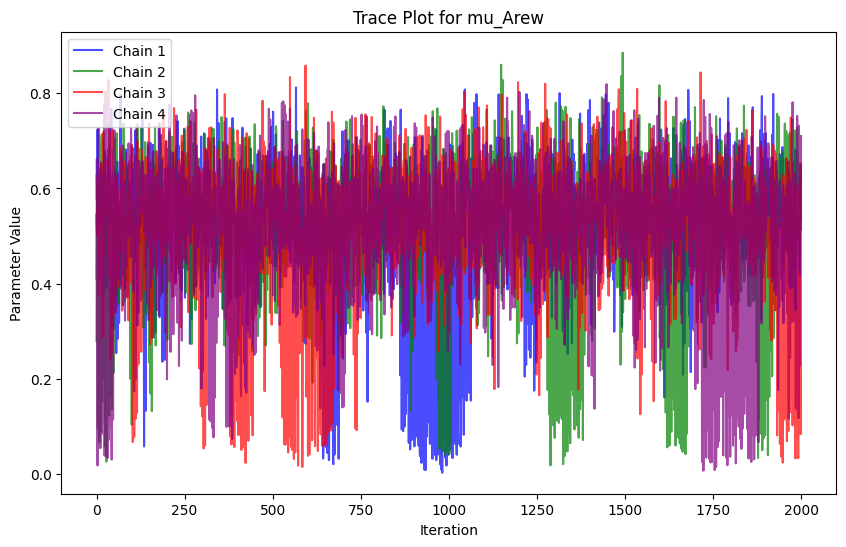

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter to plot
parameter_name = "mu_Arew"  # Change this to the parameter you want

# Convert all samples to a DataFrame
parameter_samples = fit.to_frame()

# Extract values for the specific parameter
parameter_samples = parameter_samples[parameter_name].values  # Convert to NumPy array

# Get number of chains
num_chains = fit.num_chains
num_samples_per_chain = parameter_samples.shape[0] // num_chains

# Reshape to separate chains (iterations, chains)
samples_reshaped = parameter_samples.reshape(num_chains, num_samples_per_chain).T

plt.figure(figsize=(10, 6))

# Plot samples for each chain
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']  # Add more colors if needed
for i in range(num_chains):
    plt.plot(samples_reshaped[:, i], color=colors[i % len(colors)], alpha=0.7, label=f'Chain {i + 1}')

plt.title(f'Trace Plot for {parameter_name}')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()


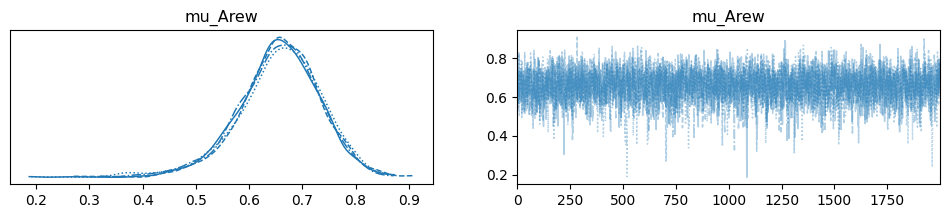

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# Define the parameter to plot
parameter_name = "mu_Arew"  # Change this to any parameter you want

# Convert PyStan 3 fit object to ArviZ InferenceData
idata = az.from_pystan(fit)

# Generate trace plot
az.plot_trace(idata, var_names=[parameter_name])

# Show the plot
plt.show()


Posterior Distribution

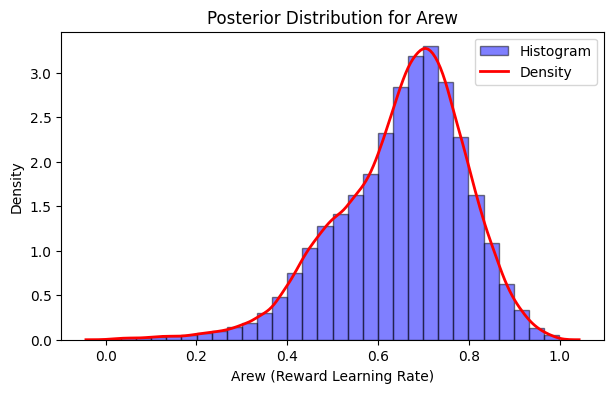

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert all posterior samples to a DataFrame
parameter_samples = fit.to_frame()

# Extract Arew samples for all subjects and flatten into one array
Arew_samples = parameter_samples.filter(like='Arew.').values.flatten()

# Plotting the posterior distribution
plt.figure(figsize=(7, 4))

# Histogram (original style)
plt.hist(Arew_samples, bins=30, density=True, alpha=0.5, color='blue', edgecolor='black', label='Histogram')

# Smooth density plot (new addition)
sns.kdeplot(Arew_samples, color='red', linewidth=2, label='Density')

plt.xlabel('Arew (Reward Learning Rate)')
plt.ylabel('Density')
plt.title('Posterior Distribution for Arew')
plt.legend()
plt.show()


Extract prediction errors

In [ ]:
import numpy as np
import pandas as pd

# **Step 1: Extract posterior samples**
posterior_samples = fit.to_frame()  # Extract posterior samples

# **Step 2: Extract only `rew_pred_error` variables**
rew_pred_error_columns = [col for col in posterior_samples.columns if "rew_pred_error" in col]
rew_pred_error = posterior_samples[rew_pred_error_columns].values  # Convert to NumPy array

# **Step 3: Debugging the extracted shape**
print("🔹 Step 3: Default shape of rew_pred_error after extraction:", rew_pred_error.shape)

# **Step 4: Extract number of subjects and their trials**
num_subjects = len(stan_data['Tsubj'])  # Number of subjects
trial_counts = np.array(stan_data['Tsubj'])  # Number of trials per subject
max_trials = max(trial_counts)  # Maximum trials across subjects
total_expected_trials = sum(trial_counts)  # The correct total trials

# **Step 5: Print extracted trial counts**
print("🔹 Step 5: Trial counts per subject:", trial_counts)
print("🔹 Step 5: Maximum trials across subjects:", max_trials)
print("🔹 Step 5: Expected total trials (sum of Tsubj):", total_expected_trials)

# **🚀 Step 6: Fix Extraction Using Subject-Wise Indexing**
# Instead of assuming trials are packed sequentially, we need to extract subject-wise trials.

rew_pred_error_fixed = np.full((8000, num_subjects, max_trials), np.nan)  # Initialize with NaNs

for i in range(num_subjects):
    num_trials = trial_counts[i]  # Correct number of trials for this subject

    # **🚨 Identify Correct Subject-Wise Trial Indices**
    subject_trial_indices = np.arange(i, rew_pred_error.shape[1], num_subjects)  # Extract every Nth entry

    # **Debugging**
    print(f"✅ Extracting trials for Subject {i+1}: Found {len(subject_trial_indices)} indices")

    # **Extract correctly & preserve NaNs if missing**
    rew_pred_error_fixed[:, i, :num_trials] = rew_pred_error[:, subject_trial_indices[:num_trials]]

# **Step 7: Verify reshaped array shape**
print("✅ Step 7: Fixed Shape of rew_pred_error after subject-wise extraction:", rew_pred_error_fixed.shape)

# **Step 8: Compute mean across posterior samples (axis=0)**
rew_pred_error_mean = np.nanmean(rew_pred_error_fixed, axis=0)

# **Step 9: Verify last subject’s extracted values**
print(f"✅ Last Subject's First 10 RPEs:", rew_pred_error_mean[-1][:10])
print(f"✅ Last Subject's Total Trials Extracted: {np.count_nonzero(~np.isnan(rew_pred_error_mean[-1]))}")

# **Step 10: Convert to DataFrame**
df_rew_errors_fixed = pd.DataFrame(rew_pred_error_mean)

# **Step 11: Rename columns for clarity**
df_rew_errors_fixed.columns = [f'Trial_{t+1}' for t in range(df_rew_errors_fixed.shape[1])]
df_rew_errors_fixed.insert(0, 'SubjectID', range(1, num_subjects + 1))

# **Step 12: Print sample of fixed data**
print("✅ Fixed reward prediction errors:")
print(df_rew_errors_fixed.head())

# **(Optional) Step 13: Save to CSV**
df_rew_errors_fixed.to_csv("reward_prediction_errors_fixed.csv", index=False)
print("✅ Fixed reward prediction errors saved to 'reward_prediction_errors_fixed.csv'")


🔹 Step 3: Default shape of rew_pred_error after extraction: (8000, 1500)
🔹 Step 5: Trial counts per subject: [300 200 200 200 200]
🔹 Step 5: Maximum trials across subjects: 300
🔹 Step 5: Expected total trials (sum of Tsubj): 1100
✅ Extracting trials for Subject 1: Found 300 indices
✅ Extracting trials for Subject 2: Found 300 indices
✅ Extracting trials for Subject 3: Found 300 indices
✅ Extracting trials for Subject 4: Found 300 indices
✅ Extracting trials for Subject 5: Found 300 indices
✅ Step 7: Fixed Shape of rew_pred_error after subject-wise extraction: (8000, 5, 300)
✅ Last Subject's First 10 RPEs: [ 0.          0.46432784  0.         -0.05192265  0.          0.44780465
  0.46432784  0.35571009  0.46432784  0.35571009]
✅ Last Subject's Total Trials Extracted: 200
✅ Fixed reward prediction errors:
   SubjectID   Trial_1   Trial_2   Trial_3   Trial_4   Trial_5   Trial_6  \
0          1  5.629339  1.862136  0.641207  0.000000  5.629339  0.000000   
1          2  0.000000  0.000000 

<ipython-input-34-c6ac6e22a309>:46: RuntimeWarning: Mean of empty slice
  rew_pred_error_mean = np.nanmean(rew_pred_error_fixed, axis=0)


In [ ]:
import numpy as np
import pandas as pd

# **Step 1: Extract posterior samples**
posterior_samples = fit.to_frame()  # Extract posterior samples

# **Step 2: Extract only `rew_pred_error` variables**
rew_pred_error_columns = [col for col in posterior_samples.columns if "rew_pred_error" in col]
rew_pred_error = posterior_samples[rew_pred_error_columns].values  # Convert to NumPy array

# **Step 3: Debugging the extracted shape**
print("🔹 Step 3: Default shape of rew_pred_error after extraction:", rew_pred_error.shape)

# **Step 4: Extract number of subjects and their trials**
num_subjects = len(stan_data['Tsubj'])  # Number of subjects
trial_counts = np.array(stan_data['Tsubj'])  # Number of trials per subject
max_trials = max(trial_counts)  # Maximum trials across subjects
total_expected_trials = sum(trial_counts)  # The correct total trials

# **Step 5: Print extracted trial counts**
print("🔹 Step 5: Trial counts per subject:", trial_counts)
print("🔹 Step 5: Maximum trials across subjects:", max_trials)
print("🔹 Step 5: Expected total trials (sum of Tsubj):", total_expected_trials)

# **🚀 Step 6: Fix Extraction Using Subject-Wise Indexing**
rew_pred_error_fixed = np.full((8000, num_subjects, max_trials), np.nan)  # Initialize with NaNs

for i in range(num_subjects):
    num_trials = trial_counts[i]  # Correct number of trials for this subject

    # **🚨 Identify Correct Subject-Wise Trial Indices**
    subject_trial_indices = np.arange(i, rew_pred_error.shape[1], num_subjects)  # Extract every Nth entry

    # **Extract correctly & preserve NaNs if missing**
    rew_pred_error_fixed[:, i, :num_trials] = rew_pred_error[:, subject_trial_indices[:num_trials]]

# **Step 7: Compute mean across posterior samples (axis=0)**
rew_pred_error_mean = np.nanmean(rew_pred_error_fixed, axis=0)

# **Step 8: Convert to New Format (Trials as Rows, Subjects as Columns)**
max_trials = rew_pred_error_mean.shape[1]
df_rew_errors_fixed = pd.DataFrame(rew_pred_error_mean.T)  # Transpose to get trials as rows
df_rew_errors_fixed.columns = [f"Subject_{i+1}" for i in range(num_subjects)]  # Rename columns
df_rew_errors_fixed.insert(0, "Trial", np.arange(1, max_trials + 1))  # Add trial numbers

# **Step 9: Print sample of fixed data**
print("✅ Fixed reward prediction errors (Subjects as Columns):")
print(df_rew_errors_fixed.head())

# **(Optional) Step 10: Save to CSV**
df_rew_errors_fixed.to_csv("reward_prediction_errors_wide.csv", index=False)
print("✅ Fixed reward prediction errors saved to 'reward_prediction_errors_wide.csv'")


🔹 Step 3: Default shape of rew_pred_error after extraction: (8000, 1500)
🔹 Step 5: Trial counts per subject: [300 200 200 200 200]
🔹 Step 5: Maximum trials across subjects: 300
🔹 Step 5: Expected total trials (sum of Tsubj): 1100
✅ Fixed reward prediction errors (Subjects as Columns):
   Trial  Subject_1  Subject_2  Subject_3  Subject_4  Subject_5
0      1   5.629339   0.000000   0.000000   0.657792   0.000000
1      2   1.862136   0.000000   0.000000   0.657792   0.464328
2      3   0.641207   0.000000   0.335915  -0.100251   0.000000
3      4   0.000000   6.676895   0.335915   0.000000  -0.051923
4      5   5.629339   0.000000  -0.026512   0.000000   0.000000
✅ Fixed reward prediction errors saved to 'reward_prediction_errors_wide.csv'


<ipython-input-35-7a1513320f13>:38: RuntimeWarning: Mean of empty slice
  rew_pred_error_mean = np.nanmean(rew_pred_error_fixed, axis=0)


Plotting y_pred

In [ ]:
# Extract y_pred from the Stan fit
y_pred = fit['y_pred']  # PyStan 3 method

# Print shape to confirm
print("Shape of y_pred before processing:", y_pred.shape)

# Fix shape if needed (should be in (8000, 5, 300))
if y_pred.shape != (8000, 5, 300):
    y_pred = np.transpose(y_pred, (2, 0, 1))  # Swap axes if needed
    print("Fixed Shape of y_pred:", y_pred.shape)



Shape of y_pred before processing: (10, 300, 8000)
Fixed Shape of y_pred: (8000, 10, 300)


subject mapping

In [ ]:
# Load dataset
data = pd.read_csv('merged_ANH_stan.csv')

# **Ensure 'subjid_num' is created before filtering**
if 'subjid_num' not in data.columns:
    subj_map = {subj: idx + 1 for idx, subj in enumerate(sorted(data['subjid'].unique()))}
    data['subjid_num'] = data['subjid'].map(subj_map)  # Create numerical subject ID

# **Filter for the same 5 subjects and first 200 trials**
num_subjects = 10
num_trials = 200

data = data[data['subjid_num'].isin(np.arange(1, num_subjects + 1))]  # Select only 5 subjects
data = data[data['trial'] <= num_trials]  # Limit to first 200 trials

# Print verification
print("Mapped Subject IDs:", data[['subjid', 'subjid_num']].drop_duplicates())
print("Final dataset shape:", data.shape)

Mapped Subject IDs:      subjid  subjid_num
0      meg1           1
300    meg2           7
500    meg3           8
700    meg4           9
900    meg5          10
1900  meg10           2
2150  meg11           3
2350  meg12           4
2550  meg13           5
2750  meg14           6
Final dataset shape: (2000, 13)


Shape of y_pred before processing: (8000, 10, 300)


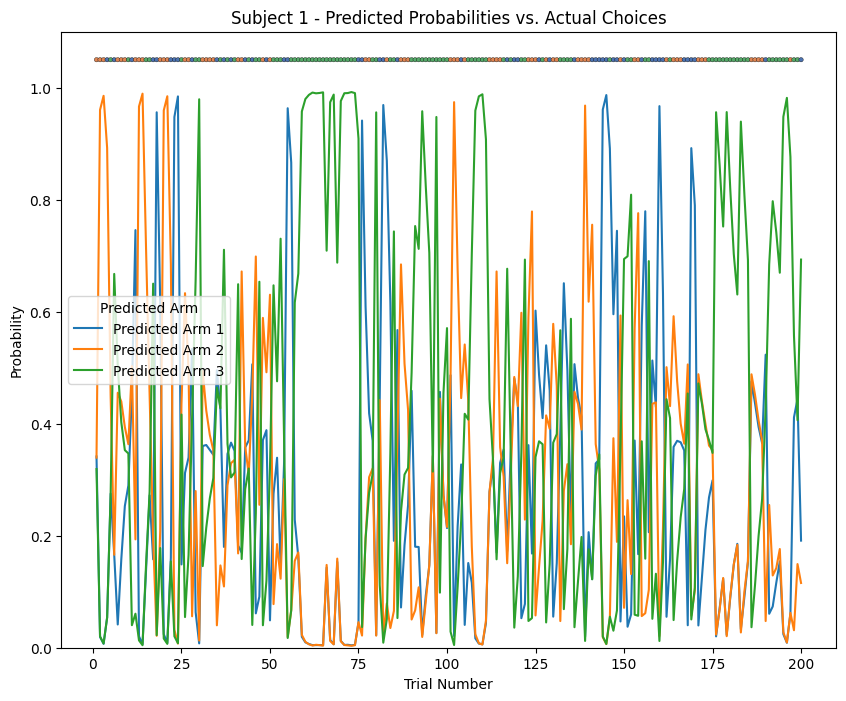

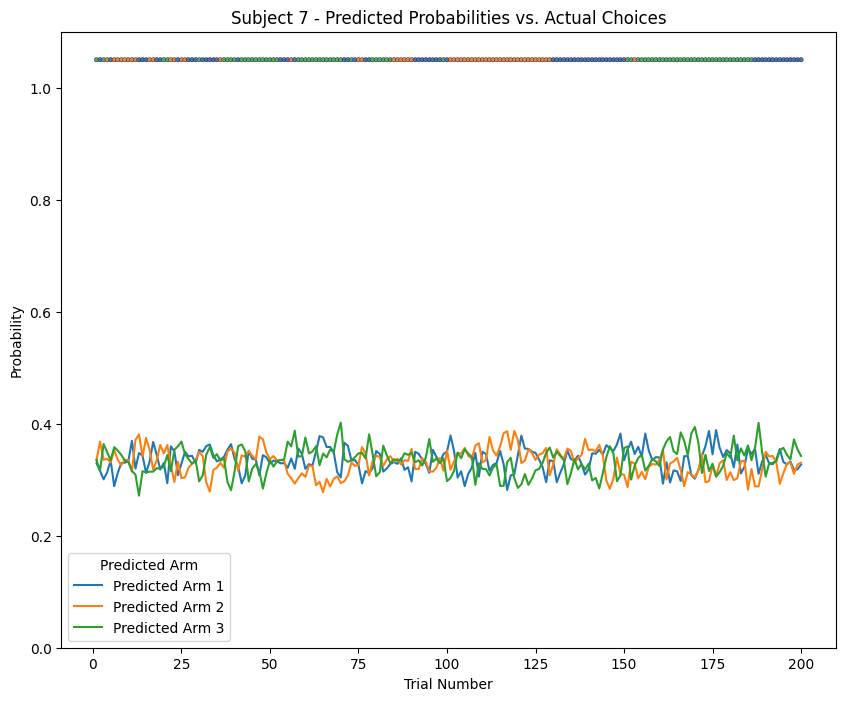

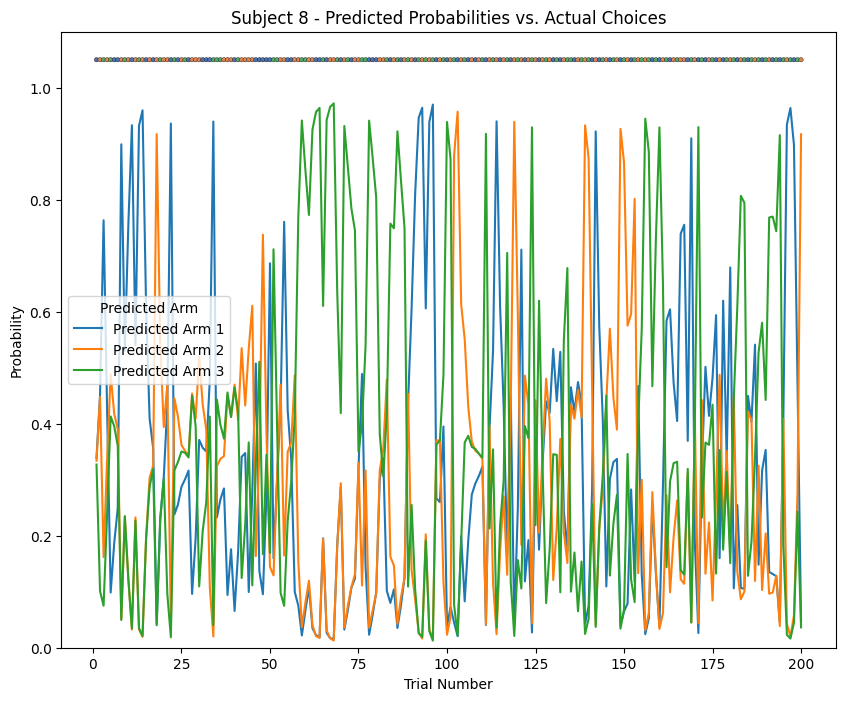

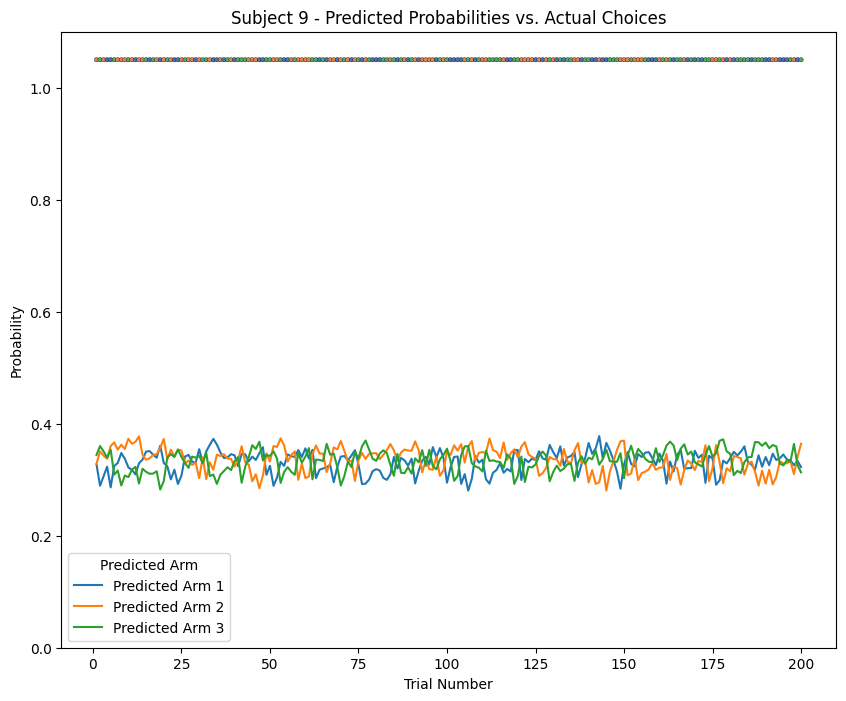

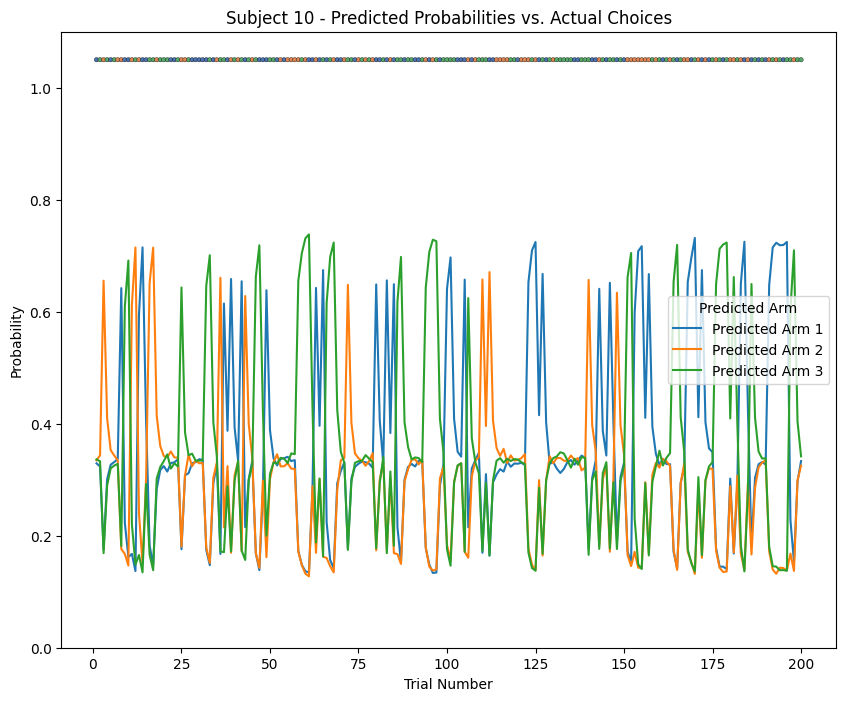

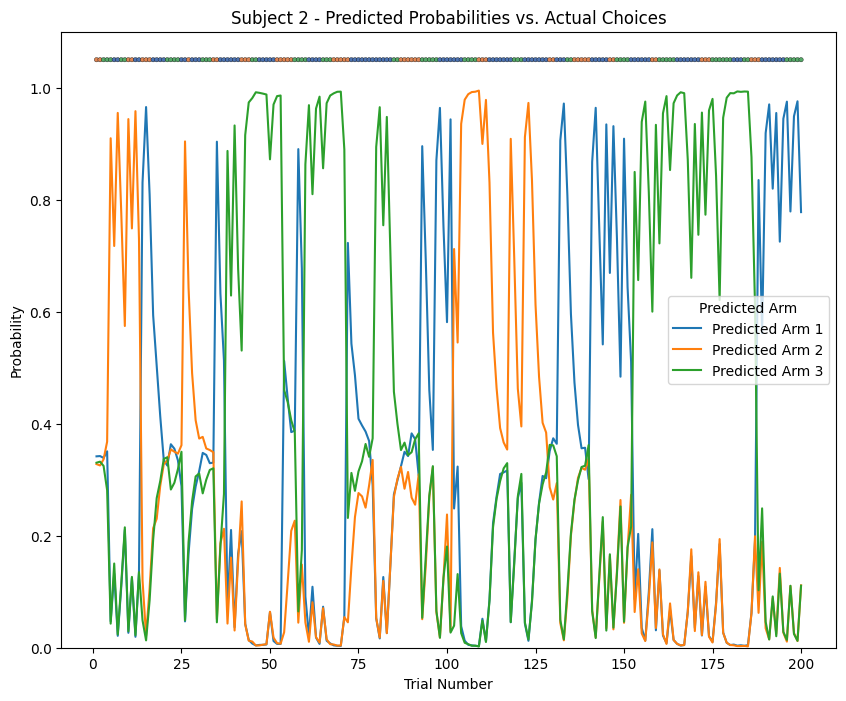

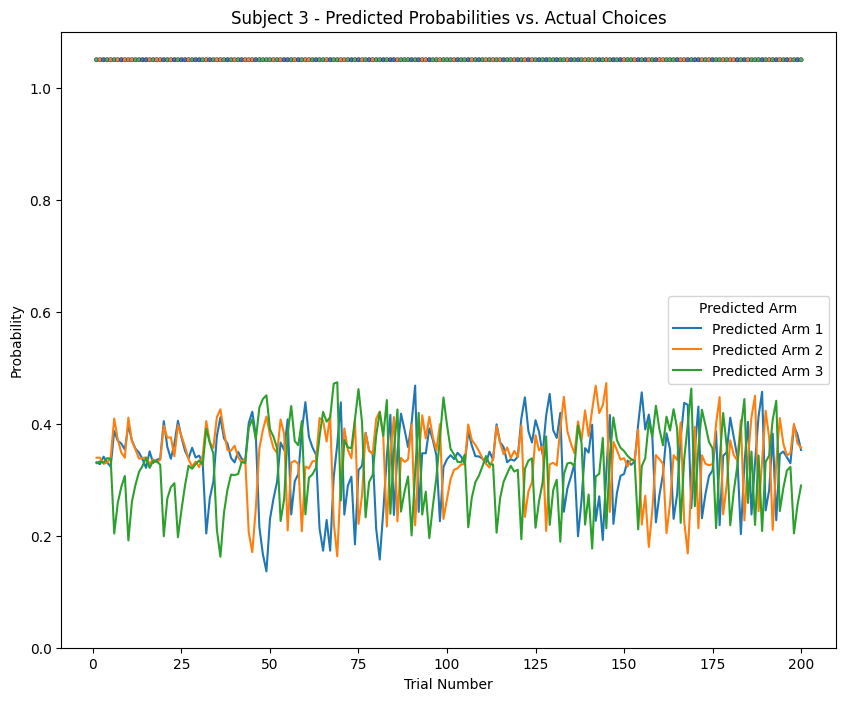

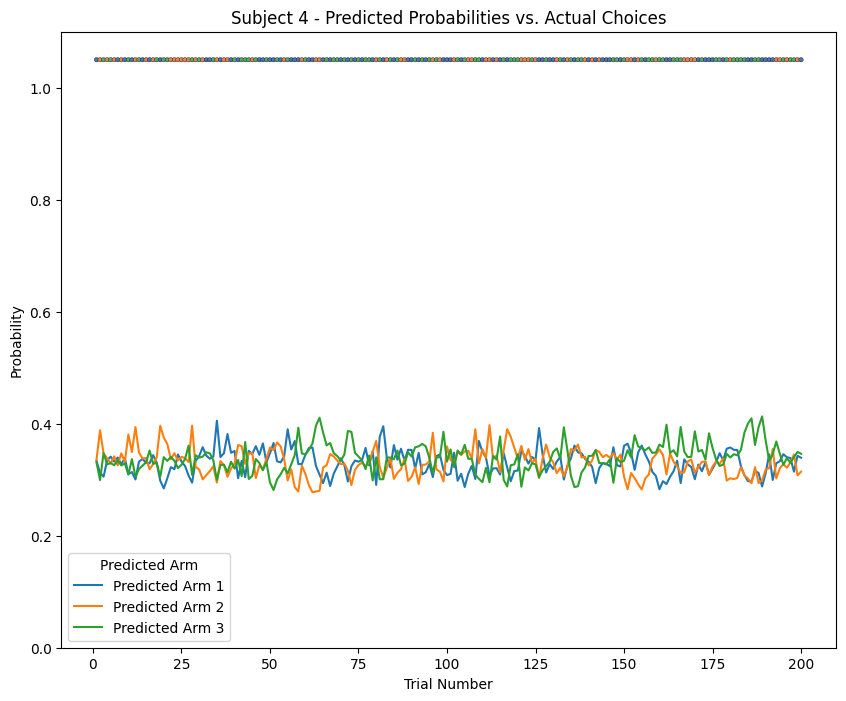

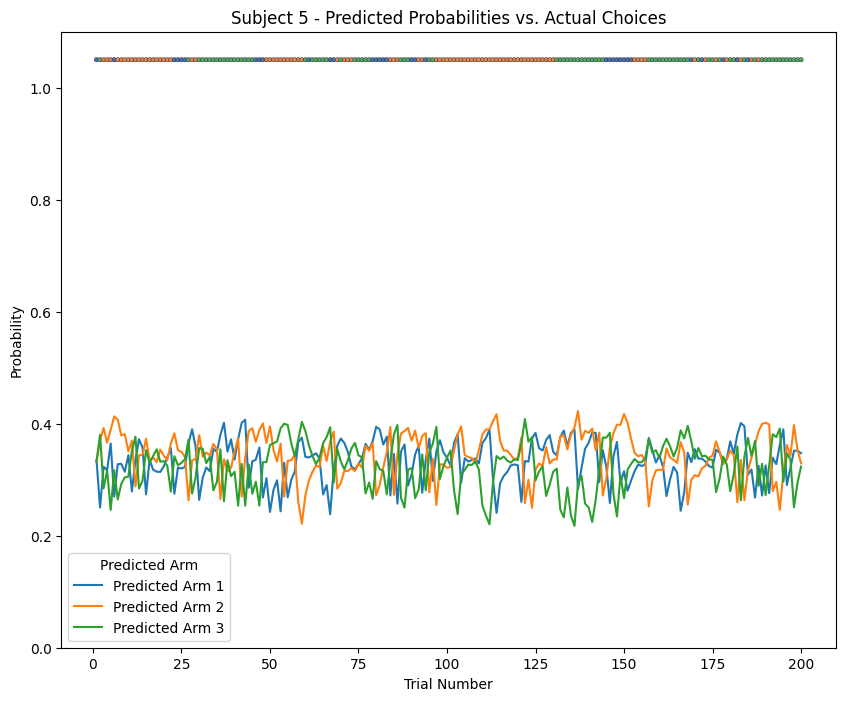

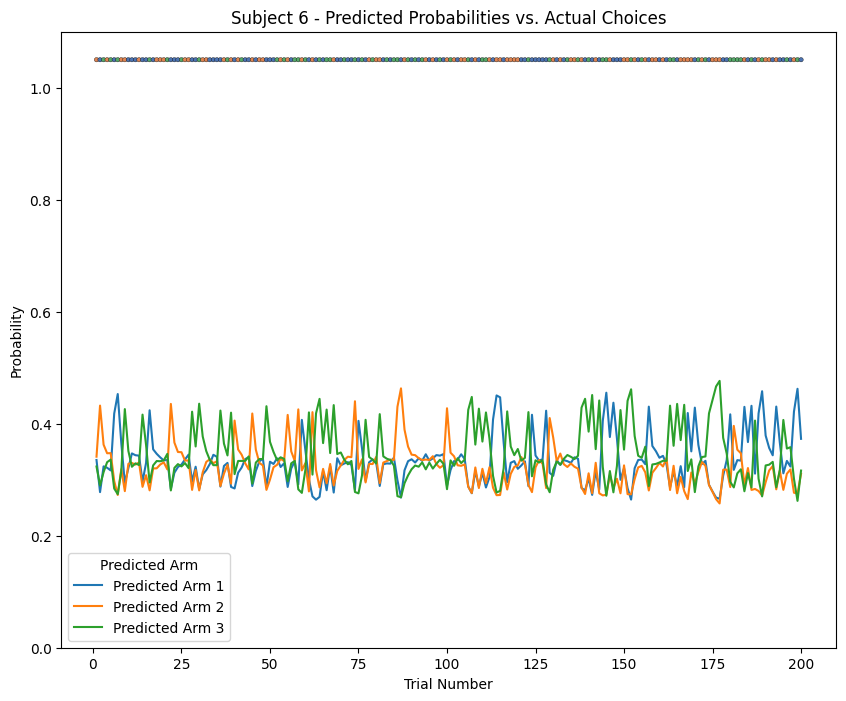

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure y_pred is in the correct shape
print("Shape of y_pred before processing:", y_pred.shape)

# Extract correct number of trials (ignoring padded -1s)
num_samples, num_subjects, num_trials = y_pred.shape  # Should be (8000, 5, 300)
num_arms = 3
num_trials = 200  # Limit to first 200 trials for visualization

# **Ignore -1 values** (only use up to each subject's actual trial count)
# Initialize one-hot encoding array
y_pred_one_hot = np.zeros((num_samples, num_subjects, num_trials, num_arms))

# Convert y_pred into one-hot encoding
for arm in range(1, num_arms + 1):
    y_pred_one_hot[..., arm - 1] = (y_pred[:, :, :num_trials] == arm)

# **Compute mean probability across samples (axis=0)**
y_pred_probabilities = np.mean(y_pred_one_hot, axis=0)  # Shape: (num_subjects, num_trials, num_arms)

# Prepare probability data for merging
prob_cols = [f'prob_arm_{i+1}' for i in range(num_arms)]
probabilities_df = pd.DataFrame(
    y_pred_probabilities.reshape(-1, num_arms), columns=prob_cols
)
probabilities_df['trial'] = np.tile(np.arange(1, num_trials + 1), num_subjects)
probabilities_df['subjid_num'] = np.repeat(np.arange(1, num_subjects + 1), num_trials)

# Merge probabilities with actual data
data_merged = pd.merge(data, probabilities_df, on=['subjid_num', 'trial'], how='left')

# **Plot Predicted Probabilities vs. Actual Choices**
for subjid in data_merged['subjid_num'].unique():
    sample_data = data_merged[data_merged['subjid_num'] == subjid]

    plt.figure(figsize=(10, 8))

    # Plot probability of each arm
    for i in range(num_arms):
        sns.lineplot(x='trial', y=f'prob_arm_{i+1}', data=sample_data, label=f'Predicted Arm {i+1}')

    # **Plot actual choices as scatter points**
    scatter_y = np.ones(len(sample_data)) * 1.05  # Position above 1 for visibility
    sns.scatterplot(x='trial', y=scatter_y, hue='choice', data=sample_data,
                    palette='deep', legend=None, s=10, marker='o', edgecolor='black')

    plt.title(f'Subject {subjid} - Predicted Probabilities vs. Actual Choices')
    plt.xlabel('Trial Number')
    plt.ylabel('Probability')
    plt.ylim(0, 1.1)
    plt.legend(title='Predicted Arm')
    plt.show()


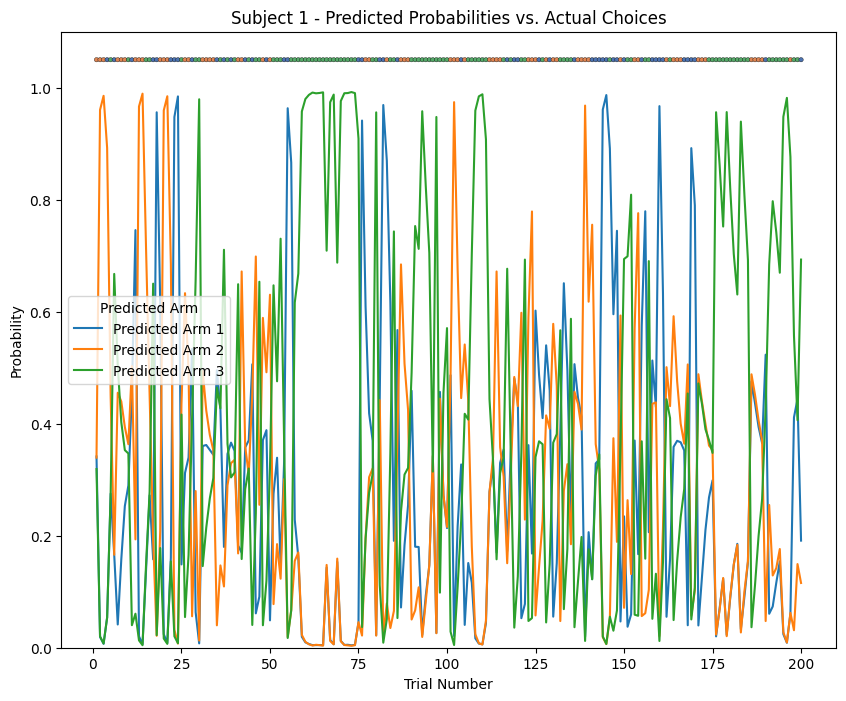

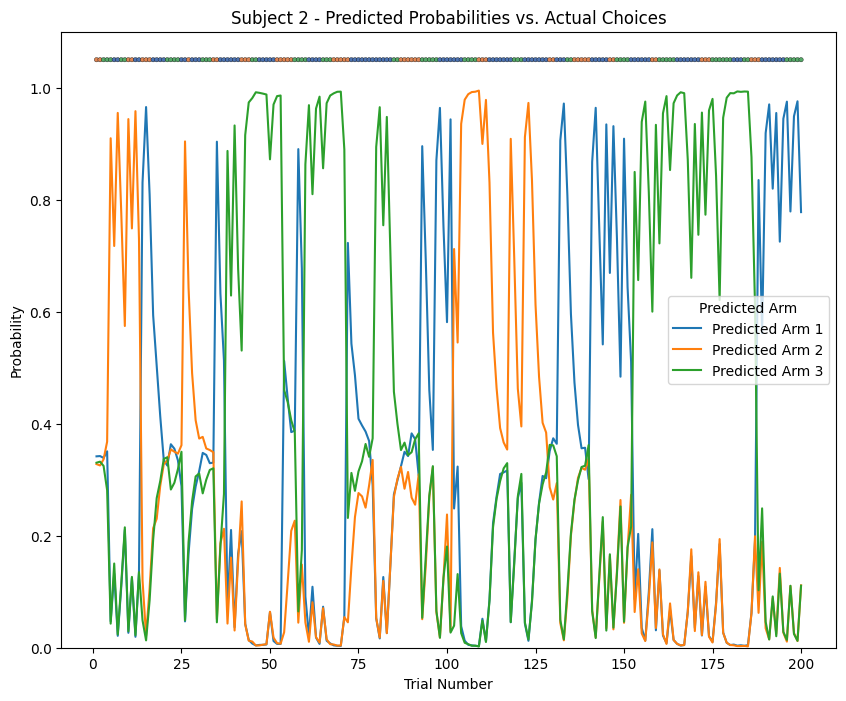

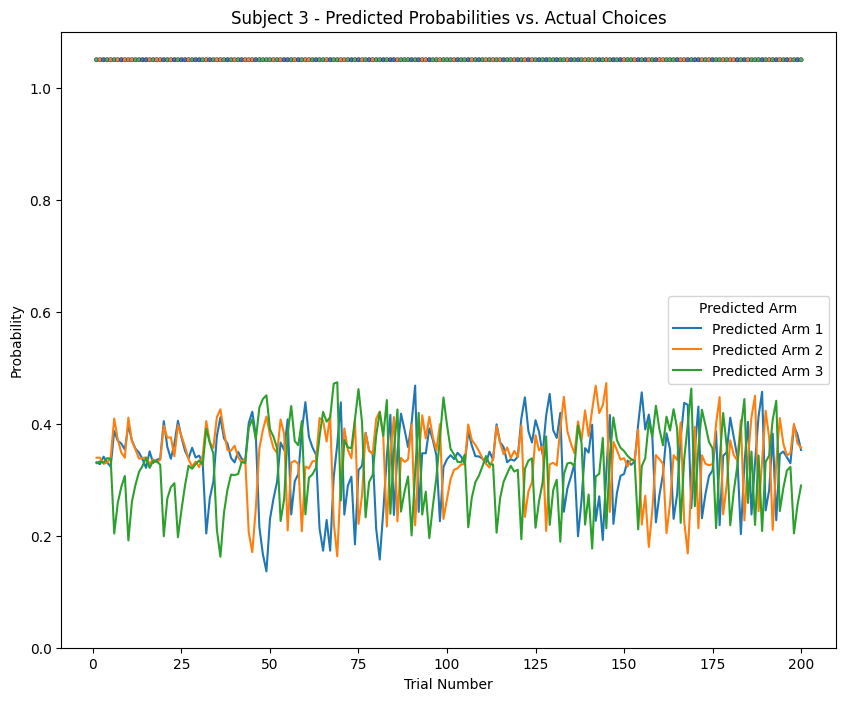

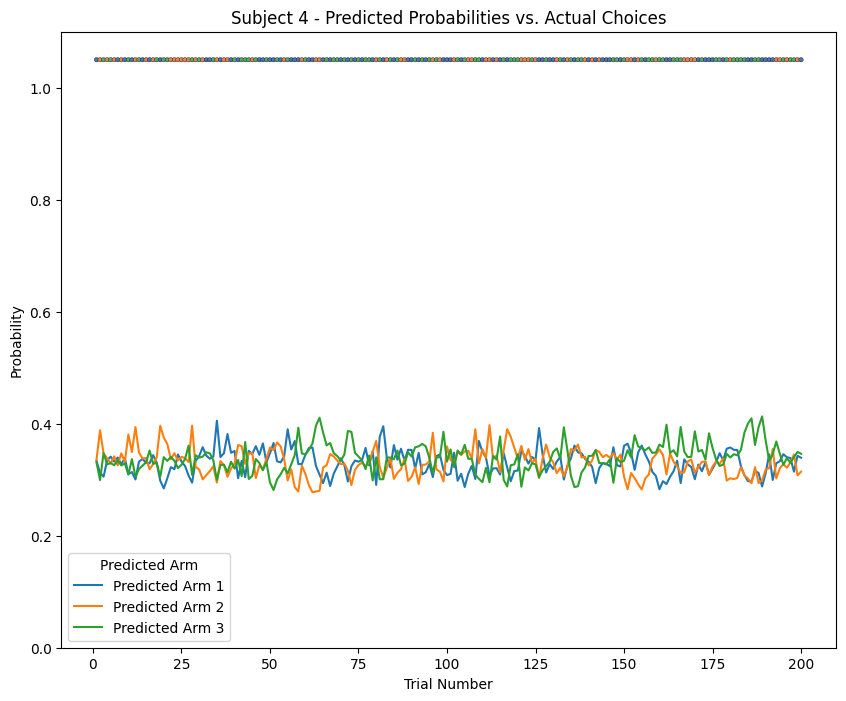

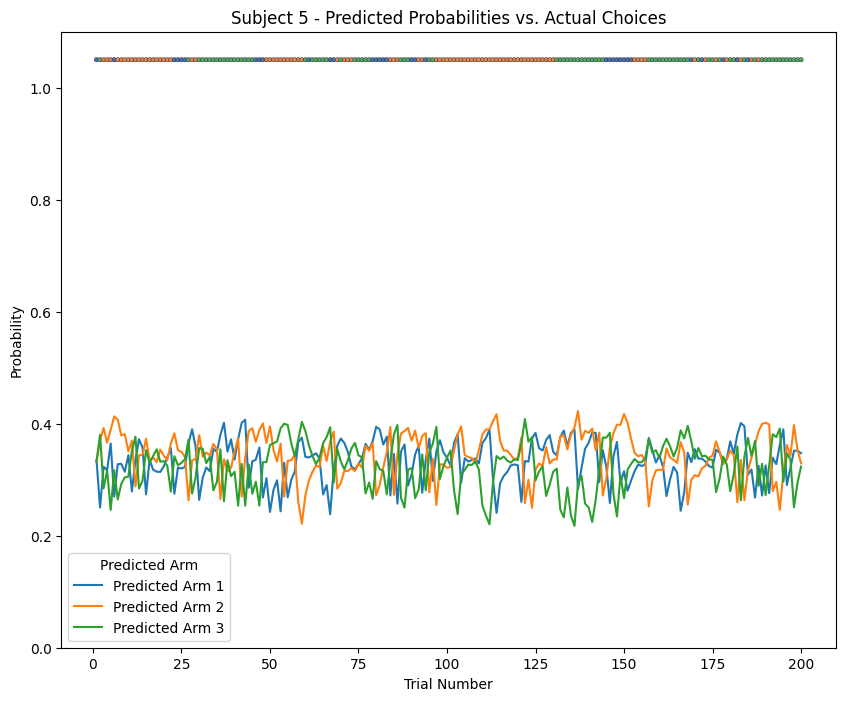

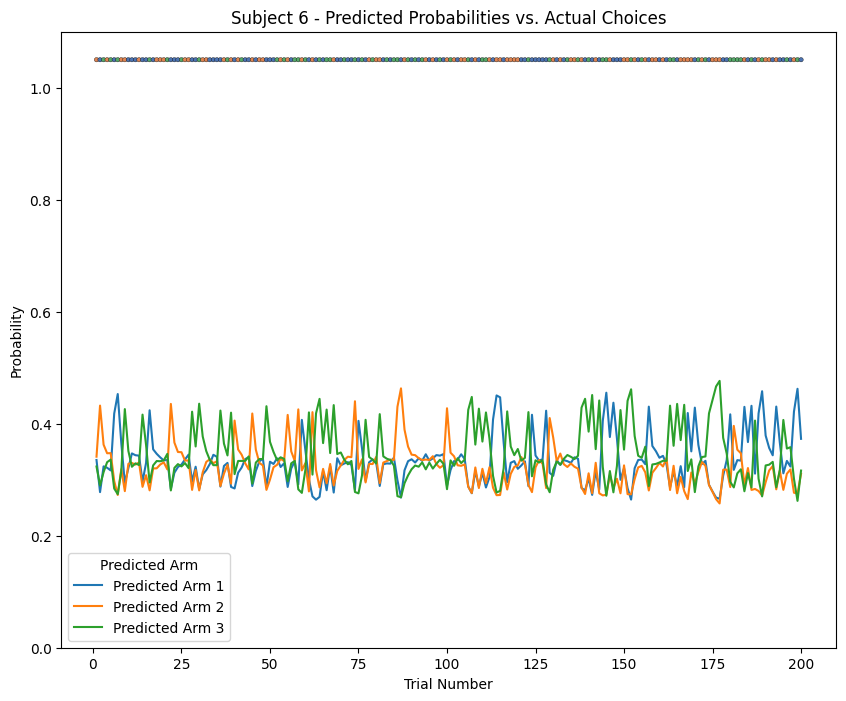

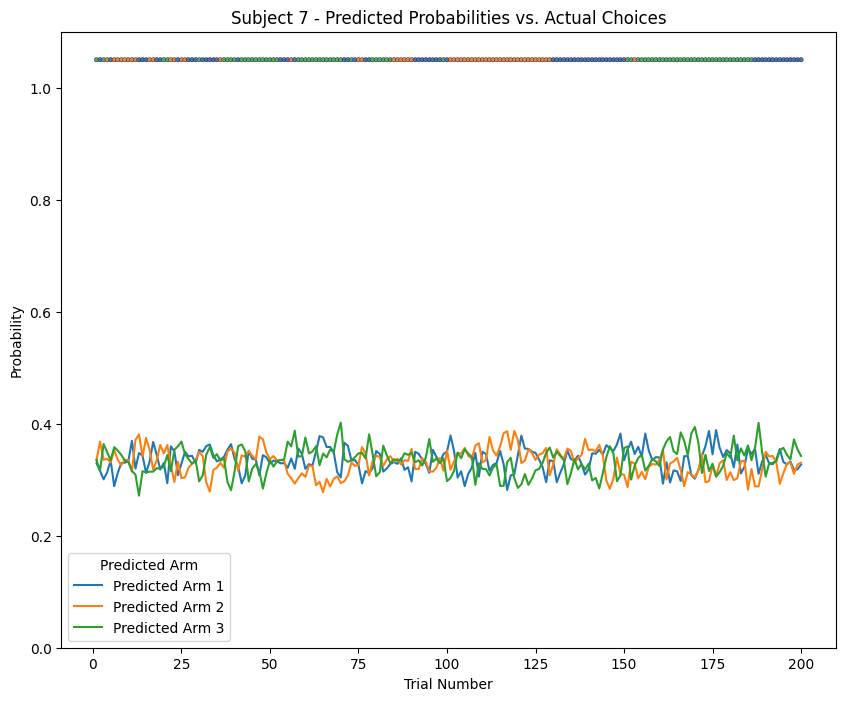

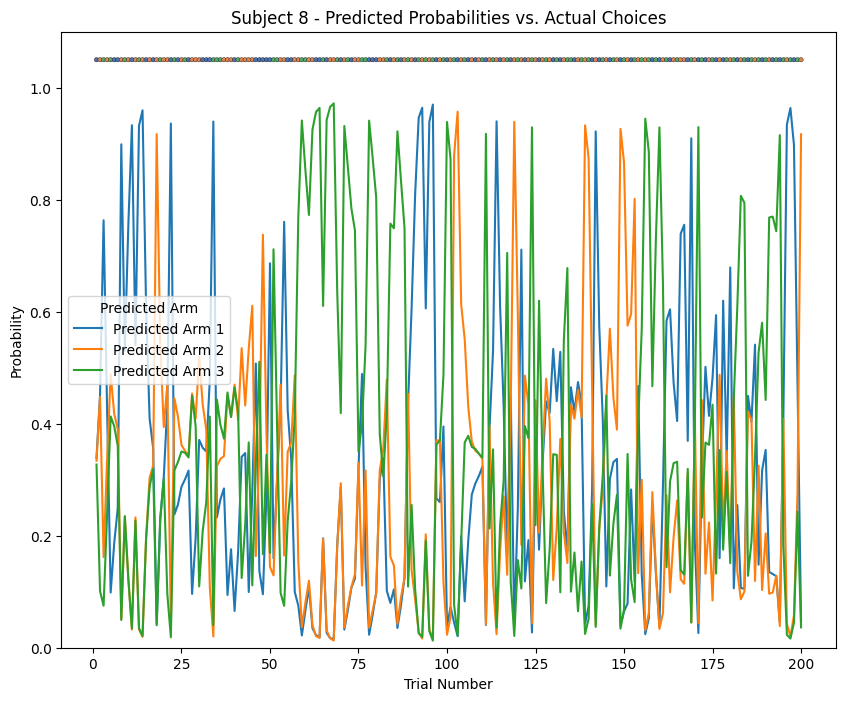

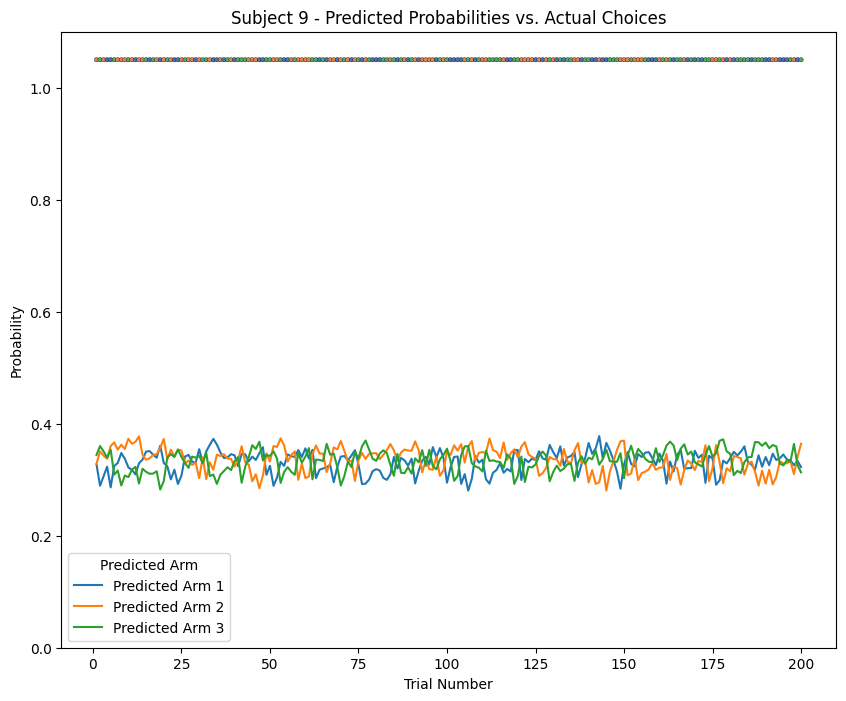

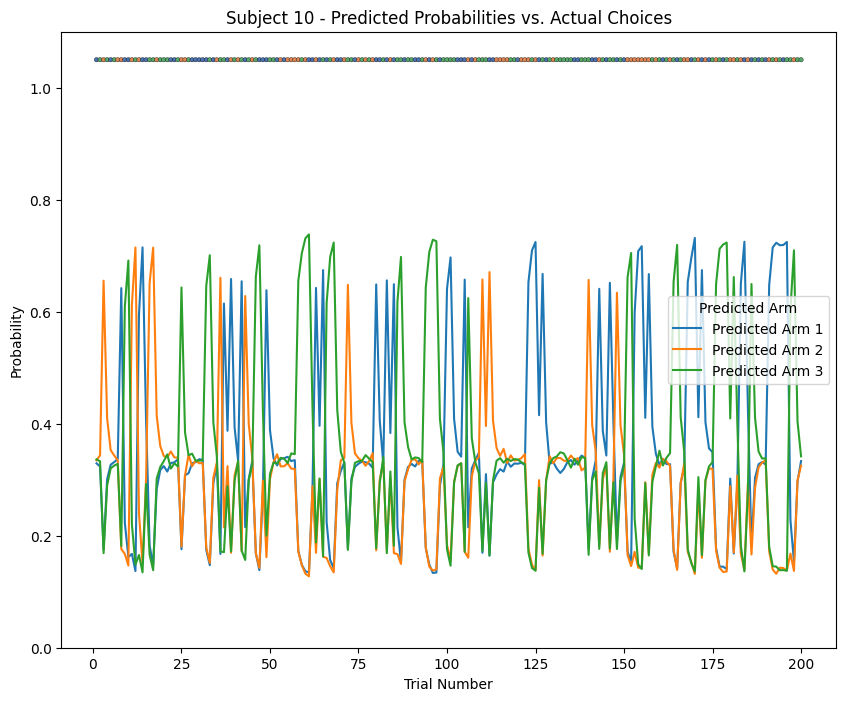

In [ ]:
# **Ensure subjects are sorted**
for subjid in sorted(data_merged['subjid_num'].unique()):  # Explicitly sort subjects
    sample_data = data_merged[data_merged['subjid_num'] == subjid]

    plt.figure(figsize=(10, 8))

    # Plot probability of each arm
    for i in range(num_arms):
        sns.lineplot(x='trial', y=f'prob_arm_{i+1}', data=sample_data, label=f'Predicted Arm {i+1}')

    # **Plot actual choices as scatter points**
    scatter_y = np.ones(len(sample_data)) * 1.05  # Position above 1 for visibility
    sns.scatterplot(x='trial', y=scatter_y, hue='choice', data=sample_data,
                    palette='deep', legend=None, s=10, marker='o', edgecolor='black')

    plt.title(f'Subject {subjid} - Predicted Probabilities vs. Actual Choices')
    plt.xlabel('Trial Number')
    plt.ylabel('Probability')
    plt.ylim(0, 1.1)
    plt.legend(title='Predicted Arm')
    plt.show()


In [ ]:
# Sum probabilities across arms for each subject and trial
prob_sum = np.sum(y_pred_probabilities, axis=2)  # Sum over the last axis (arms)

# Print summary statistics
print("Checking if predicted probabilities sum to 1 across arms:")
print("Mean sum:", np.mean(prob_sum))
print("Min sum:", np.min(prob_sum))
print("Max sum:", np.max(prob_sum))

# Check if all values are close to 1 (within small numerical error)
if np.allclose(prob_sum, 1, atol=1e-6):
    print("✅ All probability sums are correctly equal to 1!")
else:
    print("❌ Warning: Some probability sums are not 1!")

# Print a few sample values for manual verification
print("\nSample probability sums per subject per trial:")
print(prob_sum[:5, :10])  # Show first 5 subjects and 10 trials


Checking if predicted probabilities sum to 1 across arms:
Mean sum: 1.0
Min sum: 0.9999999999999999
Max sum: 1.0
✅ All probability sums are correctly equal to 1!

Sample probability sums per subject per trial:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
